<h1 align='center'>Neural Networks and Deep Learning</h1>
<img align='right' src='https://www.unidformazione.com/wp-content/uploads/2018/04/unipd-universita-di-padova.png' alt='Drawing' width='300'>


<h2 align='left'>Homework 1 - Supervised Deep Learning</h2>


<h3 align='left'>University of Padua - Physics of Data</h3>
<h4 align='left'>Dott. Alberto Testolin, Dott. Umberto Micheli</h4>

**Name** | **ID number** | **mail**@studenti.unipd.it
:-:|:-:|-:
Samuele Piccinelli | 2027650 | samuele.piccinelli

<a id='index'></a>
### Index

#### 1. [Introduction and dataset](#1)
#### 2. [Class and functions definitions](#2)
#### 3. [Training and cross-validation](#3)
#### 4. [Randomized search](#4)
#### 5. [Testing final performances](#5)
#### 6. [Conclusion](#6)

<div class='alert-success'>
<h2 align='center'>1. Regression task</h2>
</div>

In this first task we build a simple neural network model to solve a regression problem in the frame of supervised learning.

Specifically, the goal is to train a neural network able to approximate an unknown function:
$$ 
f:\mathbb{R}\to\mathbb{R} \\
x\to y=f(x) \\
\text{network}(x) \approx f(x).
$$
As training point, we have noisy measures from the target function,
$$
\hat{y} = f(x) + \text{noise}.
$$

We explore the use of advanced optimizers and regularization methods to improve convergence and promote generalization. Furthermore, the model's architecture and the learning hyperparameters are tuned using a randomized search and the final accuracy is evaluated using a cross-validation setup.

<a id='1'></a>
[Index](#index)
### 1. Introduction and dataset

We examine $100$ samples $(x,y)$ from an unknown scalar function of one variable $y=f(x)$: regression is used to estimate the form of $f$. The dataset is small an the sampling region is not uniform over its domain, characteristics that both complicate the task.

In [1]:
# Import useful libraries and dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import os
from tqdm import tqdm, trange

from sklearn.model_selection import KFold
from scipy.stats import loguniform

# Import torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchvision import transforms

We select the device used during the training and test phase: for this very simple dataset, using the CPU is faster.

In [2]:
print('Torch version:', torch.__version__)

device = 'cpu'
print(f'Using {device} for training/testing')

Torch version: 1.10.0
Using cpu for training/testing


<a id='2'></a>
[Index](#index)
### 2. Class and functions definitions

In this section we first define the function to convert the samples to `torch.tensor`, transfer them to the correct device and set the seeds for reproducibility.

In [3]:
def PandasToTensor(df, ftrs_str, lbls_str, device):
    f = torch.tensor(df[ftrs_str].to_numpy(), dtype=torch.float32).to(device)
    l = torch.tensor(df[lbls_str].to_numpy(), dtype=torch.float32).to(device)
    return f, l 

In [4]:
np.random.seed(1)
torch.manual_seed(1)
torch.cuda.manual_seed(1)

In [5]:
train_df = pd.read_csv('regression_dataset/train_data.csv')
test_df = pd.read_csv('regression_dataset/test_data.csv')

train_df.head()

,input,label
0,-4.787870,-1.216804
1,-3.509057,3.277581
2,-3.855373,2.621375
3,-4.083518,1.046088
4,-4.230588,1.228874


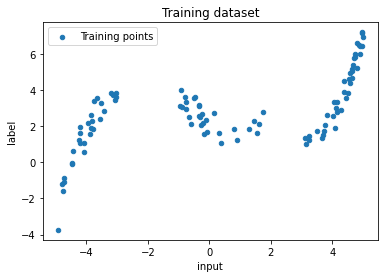

In [6]:
train_df.plot(x='input', y='label', kind='scatter', title='Training dataset', legend=True, label='Training points')
plt.show()

After loading the dataset, we construct a neural network with a customizable number of (few) hidden layers. In this simple regression setting, a simpler model is preferred over an overcomplicated one to avoid overfitting. The used parameters are listed in detail below.

* `Ni` (`int`): Number of input neurons.
* `Nh` (`tuple`): Contains the number of neurons in the `n`-th hidden layer.
* `No` (`int`): Number of output neurons.
* `act_fnc` (`str`): Activation function applied to the output of each layer, taken from the `torch.nn module`.
* `act_out` (`bool`): If `False`, no activation is applied to the very last layer. For the case of regression, no activation is needed for the output.
* `drop` (`float`): If it is $\in[0, 1)$, a dropout layer with probability `drop` is applied to every linear layer (except the final one).

To estimate generalization performance we make use of a cross-validation setup with $k$ folds, a typical approach when dealing with small training datasets. We perform a randomized search in order to find the best performing network architecture, along with the learning hyperparameters. Specifically, we run the cross-validation step for a random sampled set of hyperparameters stored in the `hparams` dictionary. More details are given below.

Coming to the training procedure, we implement the `fit` module with the following set of input parameters:

* `self` (`net`): Neural network model.
* `train_loader` (`DataLoader`): Dataloader for the train set.
* `val_loader` (`DataLoader`): Dataloader of validation set.
* `hparams` (`dict`): Hyperparameters dictionary: it contains the number of epochs, the optimizer, the loss function and the device used. An example is given by:
``` Python
hparams = {
    'n_epochs' : 250,         # Number of epochs
    'n_folds' : 5,            # Number of folds for cross-validation
    'batch_size' : 5,         # Batch size
    'lr' : 0.01,              # Learning rate
    'loss_fn' : 'MSELoss',    # Loss function
    'optimizer' : 'Adam',     # Optimizer
    'early_stopping' : False, # Bool, allows for early stopping
    'L1_reg' : 0.,            # Strength parameter for the L1 regularization
    'L2_reg' : 0.             # Strength parameter for the L2 regularization
}
```
* `show` (`bool`): If `True`, prints a progress bar and the plot of the training/validation curves.

The latter plot is obtained via the `plot_learning_curve` function and is shown together with the area around $\pm 1$ standard deviation of the average.

PyTorch optimizers have a parameter called `weight_decay` which corresponds to the L2 regularization factor; there is no analogous argument for L1, so we implement it manually following the procedure shown at [this link](https://stackoverflow.com/questions/42704283/adding-l1-l2-regularization-in-pytorch). An ad-hoc definition is preferred also for the L2 case in order to better control the type and amount of regularization.

In [7]:
def plot_learning_curve(n_epochs, train_loss_log, val_loss_log):
    epochs_train = np.arange(n_epochs) + 1
    epochs_val = np.arange(0, n_epochs, 1)
    std_loss_train = train_loss_log.std()
    std_loss_val = val_loss_log.std()

    plt.plot(epochs_train, train_loss_log, label='Train', c='b')
    plt.plot(epochs_val, val_loss_log, label='Validation', c='r')
    # Fill area between +- 1 std deviation around average
    plt.fill_between(epochs_train, train_loss_log-std_loss_train, train_loss_log+std_loss_train, alpha=.2, color='b') 
    plt.fill_between(epochs_val, val_loss_log-std_loss_val, val_loss_log+std_loss_val, alpha=.2, color='r')

    plt.title('Learning curves')
    plt.xlabel('Epoch'); plt.ylabel('Loss')
    plt.grid(True); plt.legend()
    plt.show()

In [8]:
class Net(nn.Module):

    def __init__(self, Ni, No, Nh, act_fn, act_out, drop):
        
        super().__init__()
        
        self.arguments = {
            'Ni' : Ni,
            'No' : No,
            'Nh' : Nh,
            'act_fn' : act_fn,
            'act_out' : act_out
        }

        arch = np.array([int(Ni)] + list(Nh) + [int(No)], dtype=int)
        
        self.num_layers = len(Nh) + 1 # Number of hidden + output layer
        self.layers = nn.ModuleList([nn.Linear(in_features=arch[i],\
                                               out_features=arch[i+1]) for i in range(self.num_layers)])
        self.act = getattr(nn, act_fn)()
        self.act_out = act_out

        if (drop < 1.) and (drop > 0.):
            self.dropout = True
            self.dropout_layer = nn.Dropout(drop)
        else:
            self.dropout = False

    def forward(self, x):
        # Apply act_fn to all layers but the last one
        for layer in self.layers[:-1]:
            x = self.act(layer(x))
            if self.dropout:
                x = self.dropout_layer(x)
                
        # Last layer
        x = self.layers[-1](x) 
        if (self.act_out):
            x = self.act(x)
        
        return x

    def train_step(self, data_loader, optimizer, loss_fn, L1, L2):
        train_loss = 0.
        self.train() # Training mode (e.g. enable dropout)
        for (x_batch, y_batch) in data_loader:
            # Forward pass
            out = self.forward(x_batch)
            # Compute loss 
            loss = loss_fn(out, y_batch)
            # Apply regularization
            if L1 > 0.: # L1
                for param_name, param_value in self.named_parameters():
                    if 'weight' in param_name:
                        loss += L1 * (abs(param_value)).sum()
            if L2 > 0.: # L2
                for param_name, param_value in self.named_parameters():
                    if 'weight' in param_name:
                        loss += L2 * (param_value**2).sum()
            # Backpropagation
            self.zero_grad()
            loss.backward()
            # Update the weights
            optimizer.step()
            # Save train loss for this batch
            train_loss += loss.detach().cpu().numpy()
        return train_loss / len(data_loader)

    def val_step(self, data_loader, loss_fn):
        val_loss = 0.
        self.eval() # Evaluation mode
        with torch.no_grad(): # Disable gradient tracking
            for (x_batch, y_batch) in data_loader:
                # Forward pass
                out = self.forward(x_batch)
                # Compute loss
                loss = loss_fn(out, y_batch)
                # Save val loss for this batch
                val_loss += loss.detach().cpu().numpy()
        return val_loss / len(data_loader)
    
    def fit(self, train_dataset, val_dataset, hyp_learn, show):
        # Transfer net to device: data are already loaded
        self.to(device)
        # Unpack hyperparameters' dictionary
        n_epochs   = hyp_learn['n_epochs']
        batch_size = hyp_learn['batch_size']
        lr         = hyp_learn['lr']
        
        train_loader  = DataLoader(train_dataset, batch_size, shuffle=True)
        val_loader    = DataLoader(val_dataset, batch_size, shuffle=False)
        # Define optimizers
        if hyp_learn['optimizer'] == 'SGD':
            opt = optim.SGD(self.parameters(), lr=lr, momentum=.95)
        elif hyp_learn['optimizer'] == 'Adam':
            opt = optim.Adam(self.parameters(), lr=lr)
        elif hyp_learn['optimizer'] == 'RMSprop':
            opt = optim.RMSprop(self.parameters(), lr=lr, momentum=.95)
        # Declare the loss function
        loss_fn = getattr(nn, hyp_learn['loss_fn'])()

        patience       = 10 # Threshold after which training is stopped
        patience_count = 0  # Patience counter
        min_val_loss   = math.inf
        
        train_loss_log = np.zeros(n_epochs, dtype=float)
        val_loss_log   = np.zeros(n_epochs, dtype=float)
        # Progress bar
        if show: p_bar = trange(1, n_epochs + 1)
        else: p_bar = range(1, n_epochs + 1)
        
        for epoch in p_bar:
            # Train
            train_loss = self.train_step(train_loader, opt, loss_fn, hyp_learn['L1_reg'], hyp_learn['L2_reg'])
            # Validation
            val_loss = self.val_step(val_loader, loss_fn)
            # Save train/validation loss
            train_loss_log[epoch - 1] = train_loss
            val_loss_log[epoch - 1] = val_loss
            
            if hyp_learn['early_stopping']:
                if val_loss < min_val_loss:
                    min_val_loss = val_loss
                    patience_count = 0
                else:
                    patience_count += 1

                if patience_count >= patience:
                    print('EarlySTOP')
                    break

        if show: plot_learning_curve(n_epochs, train_loss_log, val_loss_log)
            
        return train_loss_log, val_loss_log
    
    def evaluate(self, test_dataset, loss_fn, batch_size=1): # Compute accuracy for a given trained network
        self.eval()
        accuracy = []
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

        with torch.no_grad():
            for (x_batch, y_batch) in test_loader:
                out = self.forward(x_batch)
                loss = loss_fn(out, y_batch)
                loss_batch = loss.detach().cpu().numpy()
                accuracy.append(loss_batch.mean())
        return np.array(accuracy).mean()

    def restart(self):
        self.__init__()

In the following code snippet we generate the `DataLoader` of the train and validation datasets used during cross-validation. The method exploits the `KFold` function of `scipy`. The dataset specified by the couple (`features`, `labels`) (both `torch.tensor` objects) coming from the train dataset is split into a number of folds $k$ given by the variable `folds`. Samples are then batched by `DataLoaders` according to `batch_size`. The `yield` command is then responsible for returning the divided datasets during each iteration of the found `KFold` splits.

The output is fed in the `run_cross_validate` function, which implements the cross-validation loop.

In [9]:
def cross_validate(features, labels, batch_size=10, folds=5):
    
    kf = KFold(n_splits=folds, shuffle=True)

    for fold_nrx, (train_idx, val_idx) in enumerate(kf.split(features)):
        x_train, x_val = features[train_idx], features[val_idx]
        y_train, y_val = labels[train_idx], labels[val_idx]
        
        yield (TensorDataset(x_train, y_train), TensorDataset(x_val, y_val))
        
def run_cross_validate(net_class, features, labels, hyp_net, hyp_learn, show=False):
    
    n_epochs   = hyp_learn['n_epochs']
    n_folds    = hyp_learn['n_folds']
    batch_size = hyp_learn['batch_size']

    train_loss_log = np.zeros((n_epochs, n_folds), dtype=float)
    val_loss_log   = np.zeros((n_epochs, n_folds), dtype=float)

    folds = cross_validate(features, labels, batch_size, n_folds)
    # Cross-validation loop
    for fold_nr, (train_dataset, val_dataset) in enumerate(folds):
        if show: print(f'Running for fold #{fold_nr + 1}')

        net = net_class(**hyp_net) # Instantiate a new model, unpack hyp_net
        train_loss, val_loss = net.fit(train_dataset, val_dataset, hyp_learn, show)
        train_loss_log[:, fold_nr] = train_loss
        val_loss_log[:, fold_nr] = val_loss

    return train_loss_log, val_loss_log

<a id='3'></a>
[Index](#index)
### 3. Training and cross-validation

Here we give a first example in a simple configuration. The dictionaries containing the hyperparameters used for constructing the neural network and those used during the training process are listed in the cell below. A simple configuration with two hidden layers of ten neurons each is here instantiated.

A progress bar and the plot containing the training/validation loss curves is shown for each iteration.

In [10]:
# Hyperparameters used for constructing the neural network
hyp_net = {
    'Ni'  : 1,
    'No' : 1,
    'Nh' : [10,10],
    'act_fn' : 'ReLU',
    'act_out' : False,
    'drop' : -1
}

# Hyperparameters used during the training process
hyp_learn = {
    'n_epochs' : 250,
    'n_folds' : 5,
    'batch_size' : 5,
    'lr' : 0.01,
    'loss_fn' : 'MSELoss',
    'optimizer' : 'Adam',
    'early_stopping' : False,
    'L1_reg' : 0.,
    'L2_reg' : 0.
}

In [11]:
# Convert the data and move to chosen device
f_train, l_train = PandasToTensor(train_df, ['input'], ['label'], device)
f_test,  l_test  = PandasToTensor(test_df,  ['input'], ['label'], device)

Running for fold #1


100%|█████████████████████████████████████████████████████████████████████████████████| 250/250 [00:08<00:00, 29.96it/s]


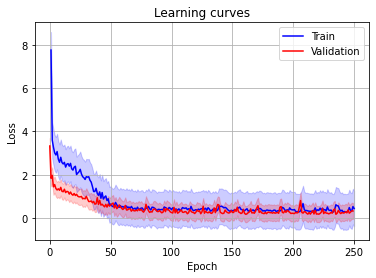

Running for fold #2


100%|█████████████████████████████████████████████████████████████████████████████████| 250/250 [00:04<00:00, 54.20it/s]


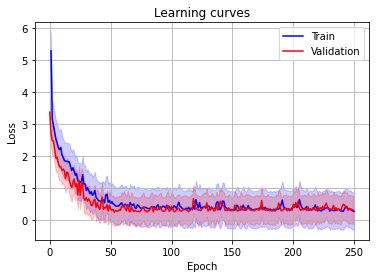

Running for fold #3


100%|█████████████████████████████████████████████████████████████████████████████████| 250/250 [00:04<00:00, 58.53it/s]


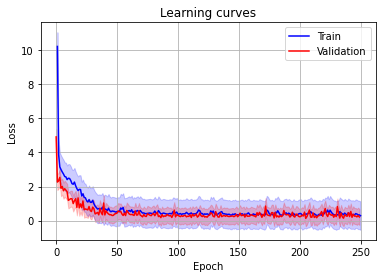

Running for fold #4


100%|█████████████████████████████████████████████████████████████████████████████████| 250/250 [00:04<00:00, 55.91it/s]


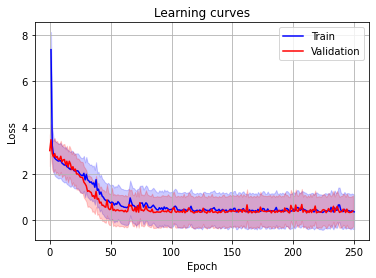

Running for fold #5


100%|█████████████████████████████████████████████████████████████████████████████████| 250/250 [00:04<00:00, 61.33it/s]


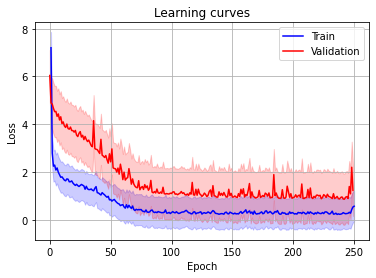

In [12]:
# Run cross-validation loop
train_loss_log, val_loss_log = run_cross_validate(Net, f_train, l_train, hyp_net, hyp_learn, show=True)

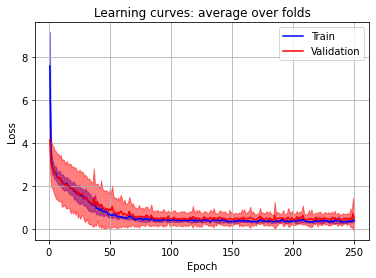

In [13]:
epochs = np.arange(hyp_learn['n_epochs']) + 1
avg_loss_train, std_loss_train = train_loss_log.mean(axis=1), train_loss_log.std(axis=1)
avg_loss_val,   std_loss_val   = val_loss_log.mean(axis=1), val_loss_log.std(axis=1)

plt.plot(epochs, avg_loss_train, label='Train', c='b')
plt.fill_between(epochs, avg_loss_train - std_loss_train, avg_loss_train + std_loss_train, alpha=.5, color='b')
plt.plot(epochs, avg_loss_val, label='Validation', c='r')
plt.fill_between(epochs, avg_loss_val - std_loss_val, avg_loss_val + std_loss_val, alpha=.5, color='r')

plt.title('Learning curves: average over folds')
plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.grid(True); plt.legend()
plt.show()

In [14]:
print('Average loss over folds\n')
print('  Train: ', np.round(np.mean(train_loss_log[-1, :]),3), '±',np.round( np.std(train_loss_log[-1, :]),3))
print('  Val:   ', np.round(np.mean(val_loss_log[-1, :]),3), '±', np.round(np.std(val_loss_log[-1, :]),3))

Average loss over folds

  Train:  0.386 ± 0.108
  Val:    0.496 ± 0.371


As we can see from this first example, the trained network reaches an acceptable generalization error. However, there is still some margin of improvement.

We will now explore a more systematic approach.

<a id='4'></a>
[Index](#index)
### 4. Randomized search

In this section we define the `random_hp_choice` function, which samples a random configuration of both network and training hyperparameters used in the randomized search. Parameters are chosen according to the following criteria.

* **Number of hidden layers**: Random (uniform) choice between a series of 4 different tuples. Configurations are initialized in order to explore an increasing depth of the network in powers of 2.
* **Regularization type**: Random (uniform) choice between dropout, L1, L2 or none.
* **Regularization strength**: Represented by the `alpha` parameter, is sampled from a log-uniform distribution in the $[10^{-5}:10^{-1}]$ range.
* **Activation function**: A random choice between Tanh, Sigmoid, ReLU and LeakyReLU. A review is given below.

\begin{align*}
\mathrm{Sig}(x)&=\frac{1}{1+e^{-x}}\\
\mathrm{ReLU}(x)&=\max(0,x)\\
\mathrm{LeakyReLU}(x)&=\max(0,x) + 0.01\cdot\min(0,x)
\end{align*}

* **Number of epochs**: Random (uniform choice) between $[50,100,150]$.
* **Number of folds**: Fixed to $k=5$.
* **Batch size**: Random (uniform) choice between $[5, 7, 10, 15]$.
* **Learning rate**: Sampled from a log-uniform distribution in the $[10^{-4}:10^{-1}]$ range.
* **Loss**: Mean squared error (MSE).
* **Optimizer**: Random (uniform) choice between Adam, RMSprop and SGD. Nesterov momentum is fixed to $0.95$ as most commonly used in the literature.

A randomized search is preferred over a grid search because the latter can be a very inefficient and extremely costly approach, both in computing power and time. By contrast, randomized search allows for an explicit control of the number of parameter combinations that are attempted, a number that is set based on time and resources. Moreover, it often outperforms grid search, obtaining more accurate results.

In [15]:
def random_hp_choice():
    hyp_net, hyp_learn = {}, {}
    
    Nh_config = [[32], [8,16], [4,8,4], [2,4,8,16]]
    nr_Nh = np.random.randint(1, len(Nh_config)+1)
    Nh = Nh_config[nr_Nh-1]
    
    reg_type = np.random.choice(['none', 'dropout', 'L1', 'L2'])
    alpha = loguniform.rvs(1e-5, 1e-1)    
    
    hyp_net = {
        'Ni' : 1,
        'No' : 1,
        'Nh' : Nh,
        'act_fn' : np.random.choice(['Tanh', 'Sigmoid', 'ReLU', 'LeakyReLU']),
        'act_out' : False,
        'drop' : alpha if reg_type == 'dropout' else 0.
    }

    hyp_learn = {
        'n_epochs': np.random.choice([50, 100, 150]).tolist(),
        'n_folds': 5,
        'batch_size': np.random.choice([5, 7, 10, 15]).tolist(),
        'lr': loguniform.rvs(1e-4, 1e-1),
        'loss_fn': 'MSELoss',
        'optimizer' : np.random.choice(['Adam', 'RMSprop', 'SGD']),
        'early_stopping' : False,
        'L1_reg': alpha if reg_type == 'L1' else 0.,
        'L2_reg': alpha if reg_type == 'L2' else 0.
    }
    
    return hyp_net, hyp_learn

The parameter `n_run` regulates the number of experiments that is conducted (500): the progress bar shows the task running. At the end, results are stored in a `Pandas.DataFrame` and the best performing network is collected. After having picked the best hyperparameters, we train the full model for longer with a decreasing learning rate. Generalization error is estimated again using cross-validation. This is done in view of the testing phase which assesses the model performance: we will come to it in the following section.

In [16]:
n_run = 500
p_bar = trange(n_run)
show = False
min_val_loss = math.inf
avg_train_loss, avg_val_loss = [], []
log_hp_net, log_hp_learn = {}, {}

for run in p_bar:
    p_bar.set_description(f'Running for task #{run+1}/{n_run}')
    hyp_net, hyp_learn = random_hp_choice()
    log_hp_net[run] = hyp_net
    log_hp_learn[run] = hyp_learn

    train_loss_log, val_loss_log = run_cross_validate(Net, f_train, l_train, hyp_net, hyp_learn, show)    

    # Log results
    final_avg_train_loss = np.mean(train_loss_log[-1, :])
    final_avg_val_loss = np.mean(val_loss_log[-1, :])
    
    avg_train_loss.append(final_avg_train_loss)
    avg_val_loss.append(final_avg_val_loss)
    
    min_val_loss = min(final_avg_val_loss, min_val_loss)

Running for task #500/500: 100%|██████████████████████████████████████████████████████| 500/500 [47:39<00:00,  5.72s/it]


In [17]:
results = pd.DataFrame({'avg_train_loss' : avg_train_loss, 'avg_val_loss' : avg_val_loss})
results.head()

,avg_train_loss,avg_val_loss
0,3.454279,4.057817
1,2.258446,2.344528
2,18.384520,26.119953
3,0.426815,0.655787
4,0.685289,0.886722


In [18]:
index = results.nsmallest(1, 'avg_val_loss').index.values.astype(int)[0]
best_hp_net = log_hp_net[index]
best_hp_learn = log_hp_learn[index]

In [19]:
best_hp_net

{'Ni': 1, 'No': 1, 'Nh': [32], 'act_fn': 'Tanh', 'act_out': False, 'drop': 0.0}

In [20]:
best_hp_learn

{'n_epochs': 100,
 'n_folds': 5,
 'batch_size': 7,
 'lr': 0.0009821701547633188,
 'loss_fn': 'MSELoss',
 'optimizer': 'RMSprop',
 'early_stopping': False,
 'L1_reg': 0.0001000252480462805,
 'L2_reg': 0.0}

The final architecture consists of a single hidden layer with $32$ neurons: of all the points of the parameter space explored over different runs this tendency is recurring, as evidence of the fact that a simpler architecture is preferred over an overcomplicated one for this task. This shows that, as for many other cases, it is often unnecessary to "use a sledgehammer to crack a nut".

The average loss over the folds for the train and validation datasets is reported below.

Running for fold #1


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:05<00:00, 76.79it/s]


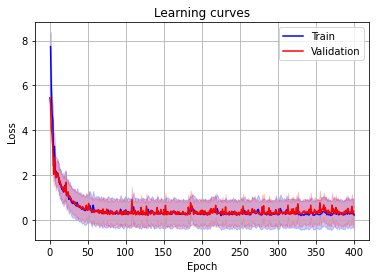

Running for fold #2


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:05<00:00, 69.11it/s]


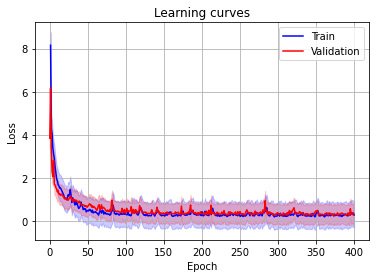

Running for fold #3


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:04<00:00, 80.23it/s]


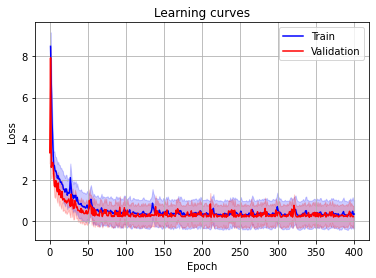

Running for fold #4


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:05<00:00, 75.65it/s]


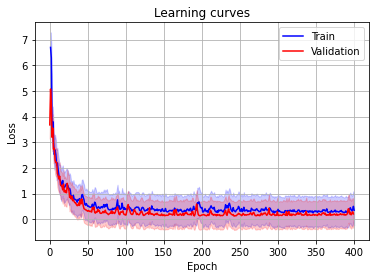

Running for fold #5


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:05<00:00, 75.54it/s]


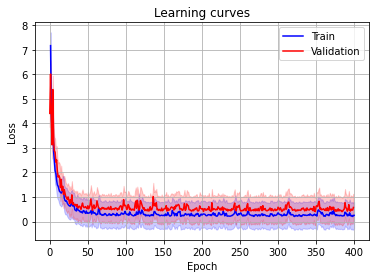

In [21]:
# Train the final network for more epochs
best_hp_learn['n_epochs'] = 400

train_loss_log, val_loss_log = run_cross_validate(Net, f_train, l_train, best_hp_net, best_hp_learn, show=True)    

In [22]:
print('Average loss over folds\n')
print('  Train: ', np.round(np.mean(train_loss_log[-1, :]),3), '±',np.round( np.std(train_loss_log[-1, :]),3))
print('  Val:   ', np.round(np.mean(val_loss_log[-1, :]),3), '±', np.round(np.std(val_loss_log[-1, :]),3))

Average loss over folds

  Train:  0.294 ± 0.042
  Val:    0.339 ± 0.14


<a id='5'></a>
[Index](#index)
### 5. Testing final performances

As anticipated, in this section we re-train the model in order to evaluate its performance on the test set. The results are good, with the test MSE reaching $\approx 0.226$ - a value smaller with respect to the one obtained in the validation phase. This latter result is probably due to the fact that the testing points show less noise than the training points and thus return a greater accordance, i.e. a closer accuracy. Moreover, in the two regions with no training samples, the curve is well reconstructed and deviates only slightly from the ground-truth.

100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 51.25it/s]


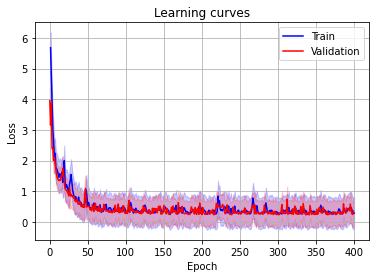

In [23]:
net = Net(**best_hp_net)
train_dataset = TensorDataset(f_train, l_train)
val_dataset = train_dataset

train_loss, val_loss = net.fit(train_dataset, val_dataset, best_hp_learn, show=True)

In [24]:
test_dataset = TensorDataset(f_test, l_test)
mse_loss = net.evaluate(test_dataset, nn.MSELoss())

print(f'MSE over the test set: {mse_loss:.3f}')

MSE over the test set: 0.226


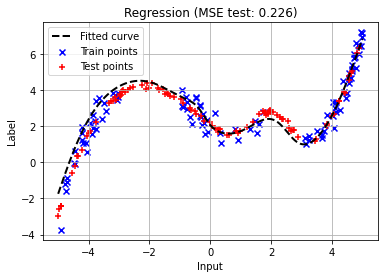

In [25]:
net = net.cpu() 
xs = np.linspace(-5, 5, 1000, dtype=np.float32)
ys = net(torch.tensor(xs).unsqueeze(1))

plt.plot(xs, ys.detach().numpy().flatten(), 'k--', lw=2, label='Fitted curve')
plt.scatter(train_df['input'], train_df['label'], c='b', marker='x', label='Train points')
plt.scatter(test_df['input'], test_df['label'], c='r', marker='+', label='Test points')
plt.title(f'Regression (MSE test: {mse_loss:.3f})')
plt.xlabel('Input'); plt.ylabel('Label')
plt.grid(True); plt.legend()
plt.show()

Finally, we visualize the output of each neuron for each of the network's layers: we build a hook and record all the activations for a range of inputs between $[-5, 5]$.

In the first layer we can see how each neuron is capable of discerning only between high or low inputs; moreover, a few of them do not activate at all, suggesting the possibility to remove them (in jargon, pruning the network) with the gained advantage of reducing the computational cost without affecting its performance. The output layer traces the final fitted function.

Lastly, we bin the weights of each layer in an histogram: results are shown below.

In [26]:
# Add a fordard_hook to each layer to record all the activations
activations = []

def record_hidden_activations(module, inp, out):
    activations.append(out.detach())

# Add hook to each layer
for layer in net.layers:
    layer.register_forward_hook(record_hidden_activations)
    
xs = np.linspace(-5, 5, 1000, dtype=np.float32)
ys = net(torch.tensor(xs).unsqueeze(1))

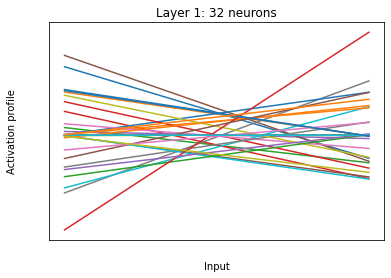

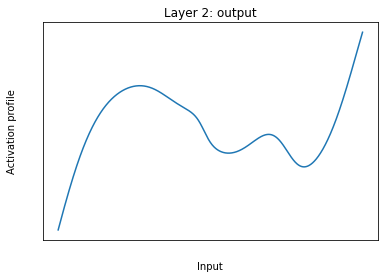

In [27]:
for num, curves in enumerate(activations):
    plt.plot(xs, curves.detach())

    if num == len(activations) - 1:
        desc = 'output'
    else:
        desc = f'{curves.shape[1]} neurons'

    plt.title(f'Layer {num+1}: {desc}')
    plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
    plt.xlabel('Input')
    plt.ylabel('Activation profile')
    plt.show()

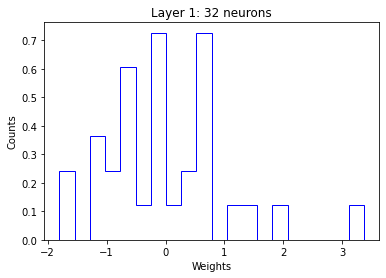

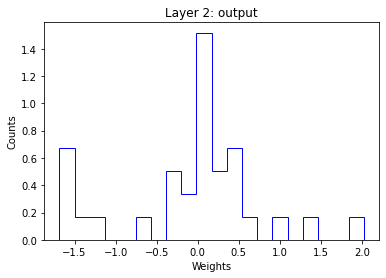

In [28]:
for num, layer in enumerate(net.layers):
    weights = layer.weight.detach().cpu().numpy()
    plt.hist(weights.flatten(), bins=20, density=True, color='b', histtype='step')
    if num == len(net.layers) - 1:
        desc = 'output'
    else:
        desc = f'{activations[num].shape[1]} neurons'

    plt.title(f'Layer {num+1}: {desc}')
    plt.xlabel('Weights')
    plt.ylabel('Counts')
    plt.show()

<a id='6'></a>
[Index](#index)
### 6. Conclusion

In this work we showed an example of regression using a simple multi-layer, fully-connected neural network. The task has been carried out using a cross-validation framework together with an extensive randomized search of the hyperparameters. The obtained results well represent the ground truth of the function: the model reaches satisfactory results with a final MSE over the test set of $\approx 0.226$.